In [ ]:
workspaceId = ''
lakehouseId = ''
timezone = "Africa/Lagos"

In [ ]:
# imports
import IPython ## not importing display because it conflicts with Fabric notebook's display() function
import polars as pl
import pandas as pd
from datetime import datetime , date
import pytz
import random



#Quick variables
my_tz = pytz.timezone(timezone)
my_tz_NOW = datetime.now(my_tz)
today = date.today()

In [ ]:
# Creating empty silver layer table definitions
# Using this to mimic the TRUNCATE -> INSERT data load method



abfs_path = f'abfss://{workspaceId}@onelake.dfs.fabric.microsoft.com/{lakehouseId}'
# crm_cust_info
crm_cust_info_schema = [
    ("cst_id", pl.Int16),
    ("cst_key", pl.Utf8),
    ("cst_firstname", pl.Utf8),
    ("cst_lastname", pl.Utf8),
    ("cst_marital_status", pl.Utf8),
    ("cst_gndr", pl.Utf8),
    ("cst_create_date", pl.Date),
    ("dwh_create_date", pl.Datetime("us", time_zone="UTC"))
]
crm_cust_info = pl.DataFrame(schema=crm_cust_info_schema)
crm_cust_info.write_delta(f"{abfs_path}/Tables/crm_cust_info", mode="overwrite")

# crm_prd_info
crm_prd_info_schema = [
    ("prd_id", pl.Int16),
    ("cat_id", pl.Utf8),
    ("prd_key", pl.Utf8),
    ("prd_nm", pl.Utf8),
    ("prd_cost", pl.Int16),
    ("prd_line", pl.Utf8),
    ("prd_start_dt", pl.Date),
    ("prd_end_dt", pl.Date),
    ("dwh_create_date", pl.Datetime("us", time_zone="UTC"))
]
crm_prd_info = pl.DataFrame(schema=crm_prd_info_schema)
crm_prd_info.write_delta(f"{abfs_path}/Tables/crm_prd_info", mode="overwrite")

# crm_sales_details
crm_sales_details_schema = [
    ("sls_ord_num", pl.Utf8),
    ("sls_prd_key", pl.Utf8),
    ("sls_cust_id", pl.Int32),
    ("sls_order_dt", pl.Date),
    ("sls_ship_dt", pl.Date),
    ("sls_due_dt", pl.Date),
    ("sls_sales", pl.Int16),
    ("sls_quantity", pl.Int16),
    ("sls_price", pl.Int16),
    ("dwh_create_date", pl.Datetime("us", time_zone="UTC"))
]
crm_sales_details = pl.DataFrame(schema=crm_sales_details_schema)
crm_sales_details.write_delta(f"{abfs_path}/Tables/crm_sales_details", mode="overwrite")

# erp_loc_a101
erp_loc_a101_schema = [
    ("cid", pl.Utf8),
    ("cntry", pl.Utf8),
    ("dwh_create_date", pl.Datetime("us", time_zone="UTC"))
]
erp_loc_a101 = pl.DataFrame(schema=erp_loc_a101_schema)
erp_loc_a101.write_delta(f"{abfs_path}/Tables/erp_loc_a101", mode="overwrite",delta_write_options={"schema_mode":"overwrite"})

# erp_cust_az12
erp_cust_az12_schema = [
    ("cid", pl.Utf8),
    ("bdate", pl.Date),
    ("gen", pl.Utf8),
    ("dwh_create_date", pl.Datetime("us", time_zone="UTC"))
]
erp_cust_az12 = pl.DataFrame(schema=erp_cust_az12_schema)
erp_cust_az12.write_delta(f"{abfs_path}/Tables/erp_cust_az12", mode="overwrite")

# erp_px_cat_g1v2
erp_px_cat_g1v2_schema = [
    ("id", pl.Utf8),
    ("cat", pl.Utf8),
    ("subcat", pl.Utf8),
    ("maintenance", pl.Utf8),
    ("dwh_create_date", pl.Datetime("us", time_zone="UTC"))
]
erp_px_cat_g1v2 = pl.DataFrame(schema=erp_px_cat_g1v2_schema)
erp_px_cat_g1v2.write_delta(f"{abfs_path}/Tables/erp_px_cat_g1v2", mode="overwrite")


In [ ]:
# loading csv files into dtaframe 

crm_cust_info = pd.read_csv(f"{abfs_path}/Files/datasets/source_crm/cust_info.csv")
crm_prd_info = pd.read_csv(f"{abfs_path}/Files/datasets/source_crm/prd_info.csv")
crm_sales_details = pd.read_csv(f"{abfs_path}/Files/datasets/source_crm/sales_details.csv")
erp_cust_az12 = pd.read_csv(f"{abfs_path}/Files/datasets/source_erp/CUST_AZ12.csv")
erp_loc_a101 = pd.read_csv(f"{abfs_path}/Files/datasets/source_erp/LOC_A101.csv")
erp_px_cat_g1v2 = pd.read_csv(f"{abfs_path}/Files/datasets/source_erp/PX_CAT_G1V2.csv")


## Transformation steps for the crm_cust_info dataframe
### Issues to fix:
- Some `cst_id` values appear more than once,  We want to keep only the latest record per customer based on the `cst_create_date`column. the column also contains some null values
- Remove whitespaces from the `cst_firstname` and `cst_lastname` columns 
- Replace **‘F’** with **‘Female’** , **‘M’** with **‘Male’**  and **Null** with **‘n/a’** in the `cst_gndr` column
- Replace **‘S’** with **'Single’** , **‘M’** with **‘Married’**  and **Null** with **‘n/a’** in the `cst_marital_status` column
- Add the `dwh_create_date` column to the dataframe 
- Make sure the data types matches the sce=hema definition



In [ ]:
def transform_crm_cust_info(df):
    start_shape = df.shape
# Remove rows with null cst_id and drop duplicate customer IDs (by keeping latest by cst_create_date)    
    print("# Removing rows with null cst_id and drop duplicate customer IDs (by keeping latest by cst_create_date)......")
    print(f"Before: {df['cst_id'].isnull().sum()} null cst_id(s)")
    print(f"Before: {df.duplicated(subset='cst_id').sum()} duplicate cst_id(s)")

    df = (df.dropna(subset=['cst_id'])
           .sort_values("cst_create_date", ascending=False)
           .drop_duplicates(subset="cst_id", keep="first") )

    print(f"After: {df['cst_id'].isnull().sum()} null cst_id(s)")
    print(f"After: {df.duplicated(subset='cst_id').sum()} duplicate cst_id(s)")

# Check, clean, and confirm whitespaces in cst_firstname and cst_lastname
    print("\nChecking, cleaning, and confirming whitespaces in cst_firstname and cst_lastname columns.........")
    first_name_ws = (df["cst_firstname"] != df["cst_firstname"].str.strip()).sum()
    last_name_ws = (df["cst_lastname"] != df["cst_lastname"].str.strip()).sum()
    print(f"{first_name_ws} rows in cst_firstname contain leading/trailing whitespace")
    print(f"{last_name_ws} rows in cst_lastname contain leading/trailing whitespace")

    df["cst_firstname"] = df["cst_firstname"].str.strip()
    df["cst_lastname"] = df["cst_lastname"].str.strip()

    print(f"Now, {(df['cst_firstname'] != df['cst_firstname'].str.strip()).sum()} rows in cst_firstname contains whitespace (should be 0)")
    print(f"Now, {(df['cst_lastname'] != df['cst_lastname'].str.strip()).sum()} rows in cst_lastname contains whitespace (should be 0)")

# Check, clean, and confirm standardization in cst_gndr
    print("\nPerforming standardization on cst_gndr column................")
    print("Unique values before standardization:", df["cst_gndr"].unique())
    df["cst_gndr"] = df["cst_gndr"].map({"F": "Female", "M": "Male"}).fillna("n/a")
    print("Unique values after standardization:", df["cst_gndr"].unique())

# Check, clean, and confirm standardization in cst_marital_status
    print("\nPerforming standardization on cst_marital_status column.............")
    print("Unique values before standardization:", df["cst_marital_status"].unique())
    df["cst_marital_status"] = df["cst_marital_status"].map({"S": "Single", "M": "Married"}).fillna("n/a")
    print("Unique values after standardization:", df["cst_marital_status"].unique())

# Creating a  dwh_create_date column as current WAT date and time
    print("\nAdding 'dwh_create_date' column with current WAT datetime..........")
    df["dwh_create_date"] = pd.to_datetime(my_tz_NOW)
    print("'dwh_create_date' column added with current datetime:", df["dwh_create_date"].iloc[0])

# Type conversion to match table schema
    print("\nPerforming Type conversion to match table schema.................")
    print(f"Before: cst_id type = {df['cst_id'].dtype}, cst_create_date type = {df['cst_create_date'].dtype}")
    df["cst_id"] = pd.to_numeric(df["cst_id"], downcast="integer")
    df["cst_create_date"] = pd.to_datetime(df["cst_create_date"]).dt.date
    #df["dwh_create_date"] = pd.to_datetime(df["dwh_create_date"]).dt.date
    print(f"After: cst_id type = {df['cst_id'].dtype}, cst_create_date type = {df['cst_create_date'].dtype}")

    end_shape = df.shape
    print(f"\nDataset shape before transformations is: {start_shape}\nDataset shape after transformations is: {end_shape}")

    return df
crm_cust_info = transform_crm_cust_info(crm_cust_info)

# Removing rows with null cst_id and drop duplicate customer IDs (by keeping latest by cst_create_date)......
Before: 4 null cst_id(s)
Before: 9 duplicate cst_id(s)
After: 0 null cst_id(s)
After: 0 duplicate cst_id(s)

Checking, cleaning, and confirming whitespaces in cst_firstname and cst_lastname columns.........
17 rows in cst_firstname contain leading/trailing whitespace
22 rows in cst_lastname contain leading/trailing whitespace
Now, 0 rows in cst_firstname contains whitespace (should be 0)
Now, 0 rows in cst_lastname contains whitespace (should be 0)

Performing standardization on cst_gndr column................
Unique values before standardization: [nan 'M' 'F']
Unique values after standardization: ['n/a' 'Male' 'Female']

Performing standardization on cst_marital_status column.............
Unique values before standardization: ['M' 'S']
Unique values after standardization: ['Married' 'Single']

Adding 'dwh_create_date' column with current WAT datetime..........
'dwh_create_date

## Transformation steps for the crm_prd_info dataframe
- Create a cat_id column by extracting the first 5 characters in the prd_key column, and replacing the ‘-’ in them with a ‘_’
- Created a new prd_key column by extracting every character from the 7th position in the original prd_key column
- Replaced null with 0 in the prd_cost column
- Replaced ‘M’ with ‘Mountain’, ‘R’ with ‘Roads’ , ‘S’ with ‘other sales’ ,’T’ with ‘Touring’ and Null with ‘n/a’  from the prd_line column
- Removed the original prd_end_date column and recreated another one by selecting the record in the next row of the prd_start_date column for each prd_key partition, and subtract the value by one i.e one day before the next start_date
- Converted the data type of both the prd_start_date and prd_end_date columns from datetime to date
Add the dwh_create_date column to the dataframe


In [ ]:
def transform_crm_prd_info(crm_prd_info):
    start_shape = crm_prd_info.shape
    # extractung cat_id from prd_key column 
    print("Creating 'cat_id' column from first 5 characters of 'prd_key'................\n This is what it looks like now:")
    crm_prd_info["cat_id"] = crm_prd_info["prd_key"].str[:5].str.replace("-", "_", regex=False)
    print(crm_prd_info[["prd_key", "cat_id"]].head(2))

    # Slicing prd_key column
    print("\nTransforming 'prd_key' by slicing from the 7th character .........\nThis is what it look like now, (compare it to the output of the previous transformation step above):")
    crm_prd_info["prd_key"] = crm_prd_info["prd_key"].str[6:]
    print(crm_prd_info[["prd_key"]].head(2))

    # Replace nulls in the prd_cost column
    print(f"\nReplacing nulls in 'prd_cost' column with 0............\nNumber of nulls before replacement: {crm_prd_info['prd_cost'].isnull().sum()}")
    crm_prd_info["prd_cost"] = crm_prd_info["prd_cost"].fillna(0)
    print(f"Number of nulls after replacement: {crm_prd_info['prd_cost'].isnull().sum()}")

    # Standardizing the prd_line column
    print("\nStandardizing values in 'prd_line' column...........\nUnique values before standardization:", crm_prd_info["prd_line"].unique())
    crm_prd_info["prd_line"] = (
        crm_prd_info["prd_line"]
        .astype(str)
        .str.upper()
        .map({
            "M ": "Mountain",
            "R ": "Roads",
            "S ": "other sales",
            "T ": "Touring"
        })
        .fillna("n/a") 
        )
    print("Unique values after standardization:", crm_prd_info["prd_line"].unique())

    # Recreating the prd_end_dt column to fix errors
    print("\nrecreating the prd_end_dt column............\nThis is what it currently looks like before transfromation ")
    crm_prd_info["prd_start_dt"] = pd.to_datetime(crm_prd_info["prd_start_dt"])
    quick_check = crm_prd_info[crm_prd_info["prd_end_dt"].notnull()][["prd_key","prd_start_dt", "prd_end_dt"]].head(5)
    print(quick_check)

    crm_prd_info = crm_prd_info.sort_values(by=["prd_key", "prd_start_dt"])
    crm_prd_info["next_start_dt"] = crm_prd_info.groupby("prd_key")["prd_start_dt"].shift(-1)
    crm_prd_info["prd_end_dt"] = crm_prd_info["next_start_dt"] - pd.Timedelta(days=1)
    crm_prd_info = crm_prd_info.drop(columns=["next_start_dt"])
    crm_prd_info = crm_prd_info.sort_values("prd_id")

    print("\nThis is what it looks like after transformation:")
    quick_check = crm_prd_info[crm_prd_info["prd_end_dt"].notnull()][["prd_key","prd_start_dt", "prd_end_dt"]].head(5)
    print(quick_check)

    # Adding the dwh_create_date column
    print("\nAdding 'dwh_create_date' column to the dataframe...............")
    crm_prd_info["dwh_create_date"] = pd.to_datetime(my_tz_NOW)
    print("dwh_create_date column added with current datetime:", crm_prd_info["dwh_create_date"].iloc[0])

    # Type conversion to match defined schema
    print("\nPerforming Type conversion to match table schema.................")
    print(f"Before: prd_id type = {crm_prd_info['prd_id'].dtype}, prd_cost type = {crm_prd_info['prd_cost'].dtype}, prd_start_dt type = {crm_prd_info['prd_start_dt'].dtype}, prd_end_dt type = {crm_prd_info['prd_end_dt'].dtype}, dwh_create_date type = {crm_prd_info['dwh_create_date'].dtype}")

    crm_prd_info["prd_id"] = pd.to_numeric(crm_prd_info["prd_id"], downcast="integer")
    crm_prd_info["prd_cost"] = pd.to_numeric(crm_prd_info["prd_cost"], downcast="integer")
    crm_prd_info["prd_start_dt"] = pd.to_datetime(crm_prd_info["prd_start_dt"]).dt.date
    crm_prd_info["prd_end_dt"] = pd.to_datetime(crm_prd_info["prd_end_dt"]).dt.date
    #crm_prd_info["dwh_create_date"] = pd.to_datetime(crm_prd_info["dwh_create_date"]).dt.date

    print(f"After: prd_id type = {crm_prd_info['prd_id'].dtype}, prd_cost type = {crm_prd_info['prd_cost'].dtype}, prd_start_dt type = {crm_prd_info['prd_start_dt'].dtype}, prd_end_dt type = {crm_prd_info['prd_end_dt'].dtype}, dwh_create_date type = {crm_prd_info['dwh_create_date'].dtype}")

    end_shape = crm_prd_info.shape

    print(f"\nDataset shape before transformations is: {start_shape}\nDataset shape after transformations is: {end_shape}")
    

    return crm_prd_info


crm_prd_info = transform_crm_prd_info(crm_prd_info)

Creating 'cat_id' column from first 5 characters of 'prd_key'................
 This is what it looks like now:
            prd_key cat_id
0  CO-RF-FR-R92B-58  CO_RF
1  CO-RF-FR-R92R-58  CO_RF

Transforming 'prd_key' by slicing from the 7th character .........
This is what it look like now, (compare it to the output of the previous transformation step above):
      prd_key
0  FR-R92B-58
1  FR-R92R-58

Replacing nulls in 'prd_cost' column with 0............
Number of nulls before replacement: 2
Number of nulls after replacement: 0

Standardizing values in 'prd_line' column...........
Unique values before standardization: ['R ' 'S ' 'M ' nan 'T ']
Unique values after standardization: ['Roads' 'other sales' 'Mountain' 'n/a' 'Touring']

recreating the prd_end_dt column............
This is what it currently looks like before transfromation 
     prd_key prd_start_dt  prd_end_dt
2  HL-U509-R   2011-07-01  2007-12-28
3  HL-U509-R   2012-07-01  2008-12-27
5    HL-U509   2011-07-01  2007-12-28
6

## Transformations for the crm_sales_details dataframe
- Check the integrity of the sls_prd_key (FK) column by checking if there are any sls_prd_key that are not available in the primary key column of the related crm_prd_info table (i.e the prd_key column)
- Check the integrity of the sls_cust_id (Foreign Key) column by checking if there are any sls_cust_id that are not available in the primary key column of the related crm_cust_info table (i.e the cst_id column) 
- Replace every record in the sls_order_date column where the length of the value is not equal to 8 or the value is 0 with Null. and converted the remaining values from integer to date type
- Create a new sls_sales column by multiplying the sls_quantity column with the absolute value of sls_price column 
- Create a new sls_price column by dividing the new sls_sales column by the sls_quantity column (and handling cases where the value in quantity column might be 0)


In [ ]:
def transform_crm_sales_details(crm_sales_details):
    start_shape = crm_sales_details.shape
    
    #STEP 1 check FK integrity - sls_prd_key
    print("Checking integrity of the sls_prd_key foreign key column...........")
    unique_sls_prd_keys = crm_sales_details["sls_prd_key"].unique()
    valid_prd_keys = crm_prd_info["prd_key"].unique()
    orphaned_prd_keys = set(unique_sls_prd_keys) - set(valid_prd_keys)
    #validate
    if orphaned_prd_keys:
        invalid_sales_records = crm_sales_details[crm_sales_details["sls_prd_key"].isin(orphaned_prd_keys)]
        print("Sample of records with invalid sls_prd_key:")
        print(invalid_sales_records.head(5))
    else:
        print("All sls_prd_key values have a matching prd_key in crm_prd_info. 😎😎")
    

    #STEP 2: Check FK integrity - sls_cust_id
    print('\nChecking Foreign Key Integrity for sls_cust_id column....................')
    unique_sls_cust_ids = crm_sales_details["sls_cust_id"].unique()
    valid_cust_ids = crm_cust_info["cst_id"].unique()
    orphaned_cust_ids = set(unique_sls_cust_ids) - set(valid_cust_ids)
    #validate
    if orphaned_cust_ids:
        invalid_sales = crm_sales_details[crm_sales_details["sls_cust_id"].isin(orphaned_cust_ids)]
        print("Sample records with invalid sls_cust_id:")
        print(invalid_sales.head())
    else:
        print('😎 All sls_cust_id values have matching cst_id values in crm_cust_info.')
    

    #STEP 3: Clean the sls_order_dt column
    print("\nCleaning the sls_order_dt column.............")
    crm_sales_details["sls_order_dt"] = crm_sales_details["sls_order_dt"].astype(str)
    error_mask = (crm_sales_details["sls_order_dt"].str.len() != 8) | (crm_sales_details["sls_order_dt"] == "0")
    print("Number of error values in sls_order_dt before transformation:", error_mask.sum())
    print("This is what they look like before cleaning: \n",crm_sales_details[error_mask].sls_order_dt.head())

    # ensure the date columns are datetime
    crm_sales_details["sls_due_dt"] = pd.to_datetime(crm_sales_details["sls_due_dt"], errors="coerce", format="%Y%m%d")
    crm_sales_details["sls_order_dt"] = pd.to_datetime(crm_sales_details["sls_order_dt"], errors="coerce", format="%Y%m%d")
    
    # fix order date
    crm_sales_details.loc[error_mask, "sls_order_dt"] = (crm_sales_details.loc[error_mask, "sls_due_dt"] - pd.Timedelta(days=12))

    # finally convert to datetime
    crm_sales_details["sls_order_dt"] = pd.to_datetime(crm_sales_details["sls_order_dt"], errors="coerce", format="%Y%m%d")
    #validate
    print("Number of errors values in sls_order_dt after transformation (must be 0):", crm_sales_details["sls_order_dt"].isna().sum())


    #STEP 4: Clean sls_ship_dt column
    print("\nEnsuring the sls_ship_dt column too is clean.............")
    crm_sales_details["sls_ship_dt"] = crm_sales_details["sls_ship_dt"].astype(str)
    error_mask = (crm_sales_details["sls_ship_dt"].str.len() != 8) | (crm_sales_details["sls_ship_dt"] == "0")
    if error_mask.any():
        print("Number of error values in sls_ship_dt before transformation:", error_mask.sum())
        print("This is what they look like before cleaning: \n",crm_sales_details[error_mask].head())

        crm_sales_details["sls_ship_dt"] = crm_sales_details["sls_ship_dt"].apply(
            lambda x: x if len(x) == 8 and x != "0" else None  )

        crm_sales_details["sls_ship_dt"] = pd.to_datetime(
            crm_sales_details["sls_ship_dt"], 
            format="%Y%m%d" )

    #validate
        print("Number of Null values in sls_ship_dt after transformation:", crm_sales_details["sls_ship_dt"].isna().sum())
        print("Sample after cleaning:")
        print(crm_sales_details["sls_ship_dt"].head())
    else:
        print("😎no errors in the sls_ship_dt column sire !!")
        crm_sales_details["sls_ship_dt"] = pd.to_datetime(crm_sales_details["sls_ship_dt"], format="%Y%m%d")


    #STEP 4: Check for date inconsistencies
    print("\nChecking for date inconsistencies........")
    crm_sales_details['sls_due_dt'] = pd.to_datetime(crm_sales_details['sls_due_dt'], format="%Y%m%d")
    order_after_ship = crm_sales_details["sls_order_dt"] > crm_sales_details["sls_ship_dt"]
    order_after_due = (crm_sales_details["sls_due_dt"] != pd.to_datetime('1970-01-01')) & (crm_sales_details["sls_order_dt"] > crm_sales_details["sls_due_dt"])
    date_issues_mask = order_after_ship | order_after_due

    #Validate 
    if date_issues_mask.any():
        print("⚠️ Found date inconsistencies where order date is later than ship or due date:")
        print(f"- Number of rows where order date > ship date: {order_after_ship.sum()}")
        print(f"- Number of rows where order date > due date: {order_after_due.sum()}")
        print("Here are some problematic rows:\n")
        print(crm_sales_details[date_issues_mask][["sls_order_dt", "sls_ship_dt", "sls_due_dt"]].head())
    else:
        print("😎 All good! No date inconsistencies found.")



    #STEP 5: Clean sls_sales and sls_price columns
    print("\nCleaning the sls_sales, and sls_price columns..........")
    invalid_sales_mask = (
        crm_sales_details["sls_sales"].isnull() |
        (crm_sales_details["sls_sales"] < 0) |  
        (crm_sales_details["sls_sales"] != crm_sales_details["sls_quantity"] * crm_sales_details["sls_price"])  
        )
    invalid_sales_count = invalid_sales_mask.sum()
    print("Before transformation, number of rows where sls_sales is null or < 0 or != sls_quantity * sls_price:",invalid_sales_count,'\nthis is what they look like:')
    print(crm_sales_details[invalid_sales_mask][[ 'sls_sales' , 'sls_quantity' , 'sls_price']].sample(n=5))
    crm_sales_details['sls_price'] = crm_sales_details.apply(lambda row: round(abs(row["sls_sales"]) / row["sls_quantity"],2) if pd.notnull(row["sls_sales"]) else row["sls_price"],axis=1)
    crm_sales_details['sls_sales'] = crm_sales_details.sls_price * crm_sales_details.sls_quantity

    # Validate
    invalid_sales_mask = (
        crm_sales_details["sls_sales"].isnull() |  
        (crm_sales_details["sls_sales"] < 0) |  
        (crm_sales_details["sls_sales"] != crm_sales_details["sls_quantity"] * crm_sales_details["sls_price"])
    )
    invalid_sales_count = invalid_sales_mask.sum()
    print("After cleaning, number of rows where sls_sales is null or < 0 or != sls_quantity * sls_price: ",invalid_sales_count)


    #STEP 6:Add the dwh_create_date column
    print("\nAdding 'dwh_create_date' column to the dataframe...............")
    crm_sales_details["dwh_create_date"] = pd.to_datetime(my_tz_NOW)
    print("dwh_create_date column added with current datetime:", crm_sales_details["dwh_create_date"].iloc[0])


    #STEP 7:Type conversion to match defined schema
    print("\nPerforming Type conversion to match table schema.................")
    print("data types before transformation\n",crm_sales_details.dtypes.to_dict())
    #clean
    crm_sales_details['sls_cust_id'] = crm_sales_details['sls_cust_id'].astype('int32')
    crm_sales_details['sls_order_dt'] = pd.to_datetime(crm_sales_details['sls_order_dt']).dt.date
    crm_sales_details['sls_ship_dt'] = pd.to_datetime(crm_sales_details['sls_ship_dt']).dt.date
    crm_sales_details['sls_due_dt'] = pd.to_datetime(crm_sales_details['sls_due_dt']).dt.date
    #crm_sales_details['dwh_create_date'] = pd.to_datetime(crm_sales_details['dwh_create_date']).dt.date
    crm_sales_details['sls_sales'] = crm_sales_details['sls_sales'].astype('int16')
    crm_sales_details['sls_quantity'] = crm_sales_details['sls_quantity'].astype('int16')
    crm_sales_details['sls_price'] = crm_sales_details['sls_price'].astype('int16')

    #validate
    print("\ndata types after transformation:\n",crm_sales_details.dtypes.to_dict())

    end_shape = crm_sales_details.shape

    print(f"\nDataset shape before transformations is: {start_shape}\nDataset shape after transformations is: {end_shape}")

    
    
    return crm_sales_details

crm_sales_details = transform_crm_sales_details(crm_sales_details)


Checking integrity of the sls_prd_key foreign key column...........
All sls_prd_key values have a matching prd_key in crm_prd_info. 😎😎

Checking Foreign Key Integrity for sls_cust_id column....................
😎 All sls_cust_id values have matching cst_id values in crm_cust_info.

Cleaning the sls_order_dt column.............
Number of error values in sls_order_dt before transformation: 19
This is what they look like before cleaning: 
 35319    0
35320    0
35321    0
35322    0
35323    0
Name: sls_order_dt, dtype: object
Number of errors values in sls_order_dt after transformation (must be 0): 0

Ensuring the sls_ship_dt column too is clean.............
😎no errors in the sls_ship_dt column sire !!

Checking for date inconsistencies........
😎 All good! No date inconsistencies found.

Cleaning the sls_sales, and sls_price columns..........
Before transformation, number of rows where sls_sales is null or < 0 or != sls_quantity * sls_price: 35 
this is what they look like:
       sls_sal

## Transformation steps for the erp_cust_az12 dataframe
- remove the string 'NAS' from the cid column
- Replace birtdates in the future with null 
- standardize gender column
- Add the dwh_create_date column

In [ ]:
def transform_erp_cust_az12(erp_cust_az12):
    start_shape = erp_cust_az12.shape
    # remove the string 'NAS' from the cid column
    print("removing the string 'NAS' from the cid column............")
    print('Unique Length of values in the cid column before transformation: ',erp_cust_az12['CID'].astype('str').str.len().unique())
    erp_cust_az12['CID'] = erp_cust_az12['CID'].astype('str').str.replace('NAS','',regex=False).str.strip()
    #check
    print('Unique Length of values in the cid column after transformation: ',erp_cust_az12['CID'].astype('str').str.len().unique())

    #Replace birtdates in the future with null 
    print('\nreplacing future burthdays with null .................,,,,,,,,,,,,')
    erp_cust_az12['BDATE'] = pd.to_datetime(erp_cust_az12['BDATE'], errors='coerce').dt.date
    print('Number of nulls before transformation: ',erp_cust_az12['BDATE'].isnull().sum())
    noFutureDates = (erp_cust_az12['BDATE'] > today).sum()
    print("number of birth dates greater than today before transformation: ",noFutureDates)
    erp_cust_az12.loc[(erp_cust_az12['BDATE'] > today), 'BDATE'] = pd.NaT
    noFutureDates = (erp_cust_az12['BDATE'] > today).sum()
    #check
    print('Number of nulls after transformation: ',erp_cust_az12['BDATE'].isnull().sum())
    print("number of birth dates greater than today after transformation: ", noFutureDates)

    #standardize gender column
    print("\nStandardizing values in the 'gen' column....................")
    print("Unique values before transformation: ", erp_cust_az12.GEN.unique())
    erp_cust_az12['GEN'] = erp_cust_az12['GEN'].astype(str).str.strip().str.lower()
    gender_map = {'m': 'Male','male': 'Male','f': 'Female','female': 'Female','': 'n/a','nan': 'n/a'}
    erp_cust_az12['GEN'] = erp_cust_az12['GEN'].map(gender_map)
    # Check
    print("Unique values in 'GEN' after cleaning:", erp_cust_az12['GEN'].unique())

    #Add the dwh_create_date column
    print("\nAdding 'dwh_create_date' column to the dataframe...............")
    erp_cust_az12["dwh_create_date"] = pd.to_datetime(my_tz_NOW)
    print("dwh_create_date column added with current datetime:", erp_cust_az12["dwh_create_date"].iloc[0])

    erp_cust_az12.columns = ['cid', 'bdate', 'gen', 'dwh_create_date']    
    
    
    end_shape = erp_cust_az12.shape
    print(f"\nDataset shape before transformations is: {start_shape}\nDataset shape after transformations is: {end_shape}")

    
    return erp_cust_az12


erp_cust_az12 = transform_erp_cust_az12(erp_cust_az12)

removing the string 'NAS' from the cid column............
Unique Length of values in the cid column before transformation:  [13 10]
Unique Length of values in the cid column after transformation:  [10]

replacing future burthdays with null .................,,,,,,,,,,,,
Number of nulls before transformation:  5
number of birth dates greater than today before transformation:  11
Number of nulls after transformation:  16
number of birth dates greater than today after transformation:  0

Standardizing values in the 'gen' column....................
Unique values before transformation:  ['Male' 'Female' '  ' ' ' 'M ' 'F ' 'F' 'M' nan]
Unique values in 'GEN' after cleaning: ['Male' 'Female' 'n/a']

Adding 'dwh_create_date' column to the dataframe...............
dwh_create_date column added with current datetime: 2025-10-23 18:29:23.680819+01:00

Dataset shape before transformations is: (18484, 3)
Dataset shape after transformations is: (18484, 4)


## Transformation for erp_loc_a101
- Remove ‘-’ from the cid column 
- Standardize the cntry column 



In [ ]:

def transform_erp_loc_a101(erp_loc_a101):
    start_shape = erp_loc_a101.shape
    erp_loc_a101.columns = ['cid','cntry']
    # Replace dashes with empty string
    print("Removing '-' characters from the 'cid' column.........")
    erp_loc_a101['cid'] = erp_loc_a101['cid'].astype(str).str.replace('-', '', regex=False)

    # validate
    print("Sample cleaned values from 'cid':")
    print(erp_loc_a101['cid'].sample(5))

    #Standardize the cntry column and add a random choice for 'unknown' countries 
    print("\nStandardizing the 'cntry' column............")
    erp_loc_a101['cntry'] = erp_loc_a101['cntry'].astype(str).str.strip()
    print("Unique values before transformation: ", erp_loc_a101.cntry.unique())
    countries = ['Australia', 'United States', 'Canada', 'Germany', 'United Kingdom', 'France']
    country_map = {
        'DE': 'Germany',
        'US': 'United States',
        'USA': 'United States',
    }

    def standardize_countries(val):
        if pd.isnull(val) or val in ['', 'nan']:
            return random.choice(countries)
        else:
            return country_map.get(val, val)
    
    erp_loc_a101['cntry'] = erp_loc_a101['cntry'].apply(standardize_countries)

    #validate
    print("Unique values in 'cntry' after standardization: ", erp_loc_a101['cntry'].unique())

    #creating the dwh_create_date column
    print("\nAdding 'dwh_create_date' column to the dataframe...............")
    erp_loc_a101["dwh_create_date"] = pd.to_datetime(my_tz_NOW)
    print("dwh_create_date column added with current datetime:", erp_loc_a101["dwh_create_date"].iloc[0])
    
    end_shape = erp_loc_a101.shape
    print(f"\nDataset shape before transformations is: {start_shape}\nDataset shape after transformations is: {end_shape}")

    

    return erp_loc_a101

erp_loc_a101 = transform_erp_loc_a101(erp_loc_a101 )


Removing '-' characters from the 'cid' column.........
Sample cleaned values from 'cid':
7046     AW00018046
5207     AW00016207
6506     AW00017506
16371    AW00027371
4943     AW00015943
Name: cid, dtype: object

Standardizing the 'cntry' column............
Unique values before transformation:  ['Australia' 'US' 'Canada' 'DE' 'United Kingdom' 'France' 'USA' 'Germany'
 'nan' '' 'United States']
Unique values in 'cntry' after standardization:  ['Australia' 'United States' 'Canada' 'Germany' 'United Kingdom' 'France']

Adding 'dwh_create_date' column to the dataframe...............
dwh_create_date column added with current datetime: 2025-10-23 18:29:23.680819+01:00

Dataset shape before transformations is: (18484, 2)
Dataset shape after transformations is: (18484, 3)


## Transformations for the erp_px_cat_g1v2 dataset
* Add the dwh_create_date to the dataset
* perform data type conversion to match the schema

In [ ]:
def transform_erp_px_cat_g1v2(erp_px_cat_g1v2):
    start_shape = erp_px_cat_g1v2.shape

    #Adding the missing category informaton 'CO_PE'
    print("Adding the missing category informaton 'CO_PE'....................")
    erp_px_cat_g1v2.loc[len(erp_px_cat_g1v2)] = ['CO_PE','Components','Pedals','Yes']
    #renaming columns to match defined schema
    erp_px_cat_g1v2.columns = ['id','cat','subcat','maintenance']
    
    # Adding the dwh_create_date column
    print("\nadding 'dwh_create_date' column to the dataframe.................")
    erp_px_cat_g1v2['dwh_create_date'] = pd.to_datetime(my_tz_NOW)
    print("dwh_create_date column added with current datetime:", erp_px_cat_g1v2["dwh_create_date"].iloc[0])

    end_shape = erp_px_cat_g1v2.shape
    print(f"\nDataset shape before transformations is: {start_shape}\nDataset shape after transformations is: {end_shape}")



    return erp_px_cat_g1v2

erp_px_cat_g1v2 = transform_erp_px_cat_g1v2(erp_px_cat_g1v2)

Adding the missing category informaton 'CO_PE'....................

adding 'dwh_create_date' column to the dataframe.................
dwh_create_date column added with current datetime: 2025-10-23 18:29:23.680819+01:00

Dataset shape before transformations is: (37, 4)
Dataset shape after transformations is: (38, 5)


### Creating Date dimenson 

In [ ]:
start_date = str(min(crm_sales_details['sls_order_dt']))
end_date= str(max(crm_sales_details['sls_order_dt']))
print(start_date, end_date)

2010-12-29 2014-01-28


In [ ]:
def DimDate(start_date, end_date):
    from pandas.tseries.offsets import MonthEnd, QuarterEnd
    
    # Create base DataFrame with dates
    dim_date = pd.DataFrame({"Date": pd.date_range(start=f'{start_date}', end=f'{end_date}', freq='D')})
    
    # Function to get end of month
    def get_end_of_month(pd_date):
        if pd_date.is_month_end == True:
            return pd_date
        else:
            return pd_date + MonthEnd(1)
    
    # Function to get end of quarter
    def get_end_of_quarter(pd_date):
        if pd_date.is_quarter_end == True:
            return pd_date
        else:
            return pd_date + QuarterEnd(1)
    
    # Add calendar-related fields
    dim_date["Day"] = dim_date["Date"].dt.day
    dim_date["Day_of_Week"] = dim_date["Date"].dt.day_name()
    dim_date["Weekday"] = dim_date["Date"].dt.weekday
    dim_date["Weekday2"] = dim_date["Date"].dt.dayofweek.apply(lambda x: ((x + 1) % 7) + 1)
    dim_date["Month"] = dim_date["Date"].dt.month
    dim_date["MonthName"] = dim_date["Date"].dt.month_name()
    dim_date["Monthshort"] = dim_date["Date"].dt.strftime("%b")
    dim_date["Quarter"] = dim_date["Date"].dt.quarter
    dim_date["Year"] = dim_date["Date"].dt.year
    dim_date["Year_Month"] = dim_date["Date"].dt.strftime("%Y_%m")
    dim_date["Month_Year"] = dim_date["Date"].dt.strftime("%B %Y") 
    dim_date["EOM"] = dim_date["Date"].dt.is_month_end
    dim_date["EndofQuarter"] = dim_date["Date"].apply(get_end_of_quarter).dt.date
    dim_date["EOQ"] = dim_date["Date"].dt.is_quarter_end
    dim_date["Date"] = dim_date["Date"].dt.date # converting the actual datetime series to just date 

    
    return dim_date

dim_date = DimDate(start_date, end_date)
dim_date.head()

,Date,Day,Day_of_Week,Weekday,Weekday2,Month,MonthName,Monthshort,Quarter,Year,Year_Month,Month_Year,EOM,EndofQuarter,EOQ
0,2010-12-29,29,Wednesday,2,4,12,December,Dec,4,2010,2010_12,December 2010,False,2010-12-31,False
1,2010-12-30,30,Thursday,3,5,12,December,Dec,4,2010,2010_12,December 2010,False,2010-12-31,False
2,2010-12-31,31,Friday,4,6,12,December,Dec,4,2010,2010_12,December 2010,True,2010-12-31,True
3,2011-01-01,1,Saturday,5,7,1,January,Jan,1,2011,2011_01,January 2011,False,2011-03-31,False
4,2011-01-02,2,Sunday,6,1,1,January,Jan,1,2011,2011_01,January 2011,False,2011-03-31,False


#### QUick checkpoint 
- check the schema of all the dataframes at this point

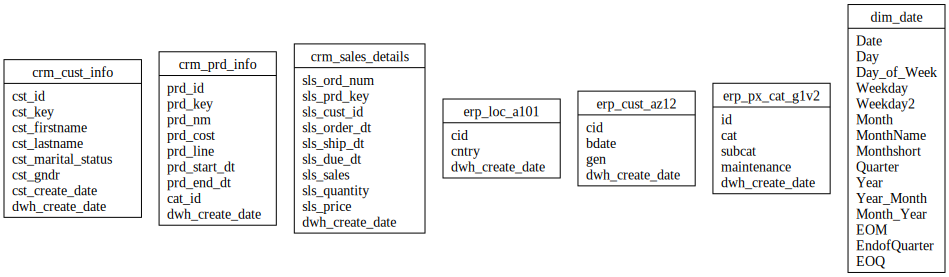

In [ ]:
dfs_info = {}
for name, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame) and not name.startswith('_'):
        dfs_info[name] = list(obj.columns)


from graphviz import Digraph

dot = Digraph(comment='Entity Diagram')

# Add each table as a node
for table, columns in dfs_info.items():
    # Create a record-style label: {TableName|col1\l col2\l ...}
    label = "{" + table + "|" + "\\l".join(columns) + "\\l}"
    dot.node(table, label=label, shape='record')

IPython.display.display(dot)



## Enriching the datasets

##### Add a City column

In [ ]:
city_map = {
    'Australia': ([
        'Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 
        'Gold Coast', 'Canberra', 'Newcastle', 'Hobart', 'Wollongong',
        'Geelong', 'Townsville', 'Cairns', 'Toowoomba', 'Darwin'
    ], [
        0.25, 0.22, 0.18, 0.12, 0.08, 
        0.05, 0.04, 0.03, 0.02, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01
    ]),
    'United States': ([
        'New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
        'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose',
        'Austin', 'Jacksonville', 'Fort Worth', 'Columbus', 'Charlotte'
    ], [
        0.15, 0.13, 0.12, 0.10, 0.09,
        0.08, 0.07, 0.06, 0.05, 0.04,
        0.03, 0.02, 0.02, 0.02, 0.01
    ]),
    'Canada': ([
        'Toronto', 'Montreal', 'Calgary', 'Ottawa', 'Edmonton',
        'Mississauga', 'Vancouver', 'Brampton', 'Hamilton', 'Surrey',
        'Quebec City', 'Laval', 'Halifax', 'London', 'Markham'
    ], [
        0.20, 0.18, 0.12, 0.10, 0.08,
        0.07, 0.06, 0.05, 0.04, 0.03,
        0.02, 0.02, 0.02, 0.01, 0.01
    ]),
    'Germany': ([
        'Berlin', 'Hamburg', 'Munich', 'Cologne', 'Frankfurt',
        'Stuttgart', 'Düsseldorf', 'Dortmund', 'Essen', 'Leipzig',
        'Bremen', 'Dresden', 'Hanover', 'Nuremberg', 'Duisburg'
    ], [
        0.18, 0.16, 0.15, 0.10, 0.09,
        0.08, 0.07, 0.06, 0.05, 0.04,
        0.03, 0.02, 0.02, 0.02, 0.01
    ]),
    'United Kingdom': ([
        'London', 'Birmingham', 'Manchester', 'Glasgow', 'Leeds',
        'Liverpool', 'Bristol', 'Sheffield', 'Edinburgh', 'Leicester',
        'Coventry', 'Kingston upon Hull', 'Bradford', 'Cardiff', 'Belfast'
    ], [
        0.25, 0.15, 0.10, 0.08, 0.07,
        0.06, 0.05, 0.04, 0.03, 0.02,
        0.02, 0.02, 0.02, 0.01, 0.01
    ]),
    'France': ([
        'Paris', 'Marseille', 'Lyon', 'Toulouse', 'Nice',
        'Nantes', 'Montpellier', 'Strasbourg', 'Bordeaux', 'Lille',
        'Rennes', 'Reims', 'Le Havre', 'Saint-Étienne', 'Toulon'
    ], [
        0.30, 0.15, 0.10, 0.08, 0.07,
        0.06, 0.05, 0.04, 0.03, 0.02,
        0.02, 0.02, 0.02, 0.01, 0.01
    ])
}

def assign_city(country):
    cities, weights = city_map.get(country, (["Unknown"], [1]))
    return random.choices(cities, weights=weights, k=1)[0]

erp_loc_a101["city"] = erp_loc_a101["cntry"].apply(assign_city)
display(erp_loc_a101[["cntry","city"]].value_counts().reset_index(name="frequency"))

## Load Dataframes into silver layer delta tables

In [ ]:
def load_tables():
    # Write crm_cust_info to silver layer delta table
    print("\nWriting crm_cust_info dataframe to silver delta table.................")
    pl.from_pandas(crm_cust_info).write_delta(f"{abfs_path}/Tables/crm_cust_info", mode="append")
    print("Silver layer table 'crm_cust_info' loaded successfully")

    # Write crm_prd_info to Silver Layer Delta Table
    print("\nWriting crm_prd_info dataframe into the silver layer delta table.................")
    pl.from_pandas(crm_prd_info).write_delta(f"{abfs_path}/Tables/crm_prd_info", mode="append")
    print("Silver layer table 'crm_prd_info' loaded successfully")  

    #Writing the crm_sales_detail dataframe to silver layer Delta Table
    print("\nWriting crm_sales_details dataframe into the silver layer delta table.................")
    pl.from_pandas(crm_sales_details).write_delta(f"{abfs_path}/Tables/crm_sales_details", mode="append")
    print("Silver layer table 'crm_sales_details' loaded successfully")

    #write erp_cust_az12 to a silver layer table
    print("\nlaading erp_cust_az12 into silver layer table.............")
    pl.from_pandas(erp_cust_az12).write_delta(f"{abfs_path}/Tables/erp_cust_az12", mode="append")
    print("Silver layer table 'erp_cust_az12' loaded successfully")

    #write the erp_loc_a101 dataset to a silver layer table
    print("\nlaading erp_loc_a101 dataframe into silver layer table.............")
    pl.from_pandas(erp_loc_a101).write_delta(f"{abfs_path}/Tables/erp_loc_a101", mode="overwrite",delta_write_options={"schema_mode":"overwrite"})
    print("Silver layer table 'erp_loc_a101' loaded successfully")

    #write the erp_px_cat_g1v2 dataset to a silver layer table
    print("\nlaading the erp_px_cat_g1v2 dataframe into silver layer table.............")
    pl.from_pandas(erp_px_cat_g1v2).write_delta(f"{abfs_path}/Tables/erp_px_cat_g1v2", mode="append")
    print("Silver layer table 'erp_px_cat_g1v2' loaded successfully")

    # Write the date dataframe to silver table 
    print("\nlaading dim_date dataframe into silver layer table.............")
    pl.from_pandas(dim_date).write_delta(f"{abfs_path}/Tables/dim_date", mode="overwrite", delta_write_options={"schema_mode":"overwrite"})
    print("Silver layer table 'dim_date' loaded successfully")


In [16]:
load_tables()


Writing crm_cust_info dataframe to silver delta table.................
Silver layer table 'crm_cust_info' loaded successfully

Writing crm_prd_info dataframe into the silver layer delta table.................
Silver layer table 'crm_prd_info' loaded successfully

Writing crm_sales_details dataframe into the silver layer delta table.................
Silver layer table 'crm_sales_details' loaded successfully

laading erp_cust_az12 into silver layer table.............
Silver layer table 'erp_cust_az12' loaded successfully

laading erp_loc_a101 dataframe into silver layer table.............
Silver layer table 'erp_loc_a101' loaded successfully

laading the erp_px_cat_g1v2 dataframe into silver layer table.............
Silver layer table 'erp_px_cat_g1v2' loaded successfully

laading dim_date dataframe into silver layer table.............
Silver layer table 'dim_date' loaded successfully
